In [48]:
!git clone https://github.com/Rene-Capistran/UTRGV-Capstone-2025

fatal: destination path 'UTRGV-Capstone-2025' already exists and is not an empty directory.


In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt


In [63]:
# ==============================
# STEP 1: LOAD AND COMBINE DATA
# ==============================
file_map = {
    'ArduinoNano': {
        'UART': [
            '/content/UTRGV-Capstone-2025/Data/Processed/Arduino_Nano_9600_dataset.csv'
        ]
    },
    'ArduinoUno': {
        'UART': [
            '/content/UTRGV-Capstone-2025/Data/Processed/Arduino_UNO_9600_dataset.csv'
        ]
    },
    'ESP32': {
        'UART': [
            '/content/UTRGV-Capstone-2025/Data/Processed/ESP_32_9600_dataset.csv'
        ]
    },
    'RaspberryPi5': {
        'UART': [
            '/content/UTRGV-Capstone-2025/Data/Processed/RPi_5B_9600_dataset.csv'
        ]
    }
}

files = []
print("Files to process:")
for device, protocols in file_map.items():
    for protocol, file_list in protocols.items():
        for file in file_list:
            print(f"  - {file}")
            files.append(file)

all_data = []
for file in files:
    print(f"\nLoading {file}...")
    df = pd.read_csv(file)
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {df.columns.tolist()}")
    print(f"  First few rows:")
    print(df.head(3))

    # Identify device family from file path
    if "UNO" in file.upper():
        device_family = "ArduinoUno"
    elif "NANO" in file.upper():
        device_family = "ArduinoNano"
    elif "ESP" in file.upper():
        device_family = "ESP32"
    elif "RPI" in file.upper():
        device_family = "RaspberryPi5"
    else:
        device_family = "Unknown"

    # Add Device_Family column (for confusion matrix - 4 classes)
    df['Device_Family'] = device_family

    # Create Full_Label (for detailed metrics - all device+label combinations)
    if 'label' in df.columns:
        df['Full_Label'] = df['Device_Family'] + "_" + df['label'].astype(str)
    else:
        df['label'] = 0
        df['Full_Label'] = df['Device_Family'] + "_0"

    all_data.append(df)
    print(f"  Added {len(df)} rows for {device_family}")

# Combine all devices
combined_df = pd.concat(all_data, ignore_index=True)
combined_df.to_csv("Combined_Device_Data.csv", index=False)
print("\n" + "="*50)
print("Combined dataset shape:", combined_df.shape)
print("Device distribution (4 families):")
print(combined_df['Device_Family'].value_counts())
print("\nDetailed label distribution (all combinations):")
print(combined_df['Full_Label'].value_counts())
print("="*50)

Files to process:
  - /content/UTRGV-Capstone-2025/Data/Processed/Arduino_Nano_9600_dataset.csv
  - /content/UTRGV-Capstone-2025/Data/Processed/Arduino_UNO_9600_dataset.csv
  - /content/UTRGV-Capstone-2025/Data/Processed/ESP_32_9600_dataset.csv
  - /content/UTRGV-Capstone-2025/Data/Processed/RPi_5B_9600_dataset.csv

Loading /content/UTRGV-Capstone-2025/Data/Processed/Arduino_Nano_9600_dataset.csv...
  Shape: (300, 23)
  Columns: ['mean_one', 'std_one', 'std_zero', 'var_one', 'var_zero', 'skew_one', 'skew_zero', 'kurt_one', 'kurt_zero', 'rms_one', 'rms_zero', 'en_one', 'en_zero', 'max_one', 'max_zero', 'min_one', 'min_zero', 'mse_one', 'cos_one', 'cos_zero', 'msg_size', 'char_len', 'label']
  First few rows:
   mean_one   std_one  std_zero   var_one  var_zero   skew_one  skew_zero  \
0  4.363303  0.021344  1.872673  0.000456  3.506903   0.508805  -1.769614   
1  4.390236  0.007868  0.433973  0.000062  0.188332 -57.934636 -11.343618   
2  4.651824  0.012953  0.010991  0.000168  0.000121 

In [64]:
# ==============================
# STEP 2: PREPARE FEATURES AND TARGET
# ==============================
# NOTE: The input CSVs already contain extracted features (mean_one, std_one, etc.)
# for each sample/window. We will use these rows directly instead of aggregating them.

features_df = combined_df.copy()

# Use numeric columns as features, excluding labels and metadata
exclude_cols = ['Device_Family', 'Full_Label', 'label', 'msg_size']
feature_cols = [col for col in features_df.columns
                if features_df[col].dtype in [np.float64, np.int64]
                and col not in exclude_cols]

print(f"\nUsing {len(feature_cols)} features for training")
print(f"Feature columns: {feature_cols}")

X = features_df[feature_cols]
y_full = features_df['Full_Label']  # Detailed labels (device + label)
y_family = features_df['Device_Family']  # Family labels only

# Handle NaN values
initial_rows = len(X)
X = X.fillna(0)  # Fill NaN with 0 instead of dropping
print(f"Filled {X.isna().sum().sum()} NaN values with 0.")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode labels
le_full = LabelEncoder()
y_full_encoded = le_full.fit_transform(y_full)

le_family = LabelEncoder()
y_family_encoded = le_family.fit_transform(y_family)

print(f"\nFinal dataset shape: {X_scaled.shape}")
print(f"Number of detailed classes: {len(le_full.classes_)}")
print(f"Detailed classes: {le_full.classes_}")
print(f"Number of device families: {len(le_family.classes_)}")
print(f"Device families: {le_family.classes_}")



Using 21 features for training
Feature columns: ['mean_one', 'std_one', 'std_zero', 'var_one', 'var_zero', 'skew_one', 'skew_zero', 'kurt_one', 'kurt_zero', 'rms_one', 'rms_zero', 'en_one', 'en_zero', 'max_one', 'max_zero', 'min_one', 'min_zero', 'mse_one', 'cos_one', 'cos_zero', 'char_len']
Filled 0 NaN values with 0.

Final dataset shape: (1211, 21)
Number of detailed classes: 18
Detailed classes: ['ArduinoNano_A' 'ArduinoNano_B' 'ArduinoUno_A' 'ArduinoUno_B'
 'ArduinoUno_C' 'ArduinoUno_D' 'ArduinoUno_E' 'ArduinoUno_F'
 'ArduinoUno_G' 'ESP32_A' 'ESP32_B' 'ESP32_C' 'ESP32_D' 'ESP32_E'
 'ESP32_F' 'ESP32_G' 'RaspberryPi5_A' 'RaspberryPi5_B']
Number of device families: 4
Device families: ['ArduinoNano' 'ArduinoUno' 'ESP32' 'RaspberryPi5']


In [74]:
# ==============================
# STEP 3: TRAIN/TEST SPLIT
# ==============================
X_train, X_val, y_train_full, y_val_full, y_train_family, y_val_family = train_test_split(
    X_scaled, y_full_encoded, y_family_encoded,
    test_size=0.2,
    stratify=y_full_encoded,
    random_state=42
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")


Training set size: 968
Validation set size: 243


In [75]:
# ==============================
# STEP 3: TRAIN/TEST SPLIT
# ==============================
# Stratify by Full_Label to ensure all classes are in train and test
X_train, X_val, y_train_full, y_val_full, y_train_family, y_val_family = train_test_split(
    X_scaled, y_full_encoded, y_family_encoded,
    test_size=0.2,
    stratify=y_full_encoded,  # Changed to stratify by full labels so we get all classes
    random_state=42
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")


Training set size: 968
Validation set size: 243


In [76]:
# ==============================
# STEP 4: TRAIN MODELS
# ==============================
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, class_weight='balanced'),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
}

trained_models = {}
results = []
all_predictions = []

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print('='*50)
    model.fit(X_train, y_train_full)
    y_pred = model.predict(X_val)

    all_predictions.append(y_pred)
    accuracy = np.mean(y_pred == y_val_full)
    results.append((name, accuracy))
    trained_models[name] = model

    print(f"{name} Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Summary
print("\n" + "="*50)
print("MODEL ACCURACY SUMMARY (DETAILED LABELS)")
print("="*50)
for name, acc in results:
    print(f"{name:25s}: {acc:.4f} ({acc*100:.2f}%)")



Training RandomForest...
RandomForest Accuracy: 0.8519 (85.19%)

Training SVM...
SVM Accuracy: 0.6049 (60.49%)

Training KNN...
KNN Accuracy: 0.6831 (68.31%)

Training LogisticRegression...
LogisticRegression Accuracy: 0.5926 (59.26%)

Training XGBoost...
XGBoost Accuracy: 0.8642 (86.42%)

MODEL ACCURACY SUMMARY (DETAILED LABELS)
RandomForest             : 0.8519 (85.19%)
SVM                      : 0.6049 (60.49%)
KNN                      : 0.6831 (68.31%)
LogisticRegression       : 0.5926 (59.26%)
XGBoost                  : 0.8642 (86.42%)


In [77]:
# ==============================
# STEP 5: ENSEMBLE PREDICTIONS
# ==============================
all_predictions = np.array(all_predictions)
ensemble_predictions = []
for i in range(all_predictions.shape[1]):
    votes = all_predictions[:, i]
    ensemble_predictions.append(np.bincount(votes).argmax())

ensemble_predictions = np.array(ensemble_predictions)
y_pred_full_decoded = le_full.inverse_transform(ensemble_predictions)
y_val_full_decoded = le_full.inverse_transform(y_val_full)

ensemble_accuracy = np.mean(ensemble_predictions == y_val_full)
print(f"\n{'='*50}")
print(f"ENSEMBLE ACCURACY: {ensemble_accuracy:.4f} ({ensemble_accuracy*100:.2f}%)")
print('='*50)

# Detailed classification report
print("\n" + "="*50)
print("ENSEMBLE CLASSIFICATION REPORT (ALL DETAILED LABELS)")
print("="*50)
print(classification_report(y_val_full_decoded, y_pred_full_decoded, zero_division=0))


ENSEMBLE ACCURACY: 0.7984 (79.84%)

ENSEMBLE CLASSIFICATION REPORT (ALL DETAILED LABELS)
                precision    recall  f1-score   support

 ArduinoNano_A       0.97      1.00      0.98        30
 ArduinoNano_B       1.00      0.97      0.98        30
  ArduinoUno_A       0.54      0.70      0.61        10
  ArduinoUno_B       0.67      0.67      0.67         9
  ArduinoUno_C       0.67      0.44      0.53         9
  ArduinoUno_D       0.88      0.78      0.82         9
  ArduinoUno_E       0.45      0.56      0.50         9
  ArduinoUno_F       0.80      0.44      0.57         9
  ArduinoUno_G       0.25      0.33      0.29         9
       ESP32_A       1.00      1.00      1.00        10
       ESP32_B       0.50      0.44      0.47         9
       ESP32_C       0.88      0.78      0.82         9
       ESP32_D       0.78      0.78      0.78         9
       ESP32_E       1.00      0.89      0.94         9
       ESP32_F       0.75      0.90      0.82        10
       ESP32_


CONFUSION MATRIX 1: DEVICE FAMILIES


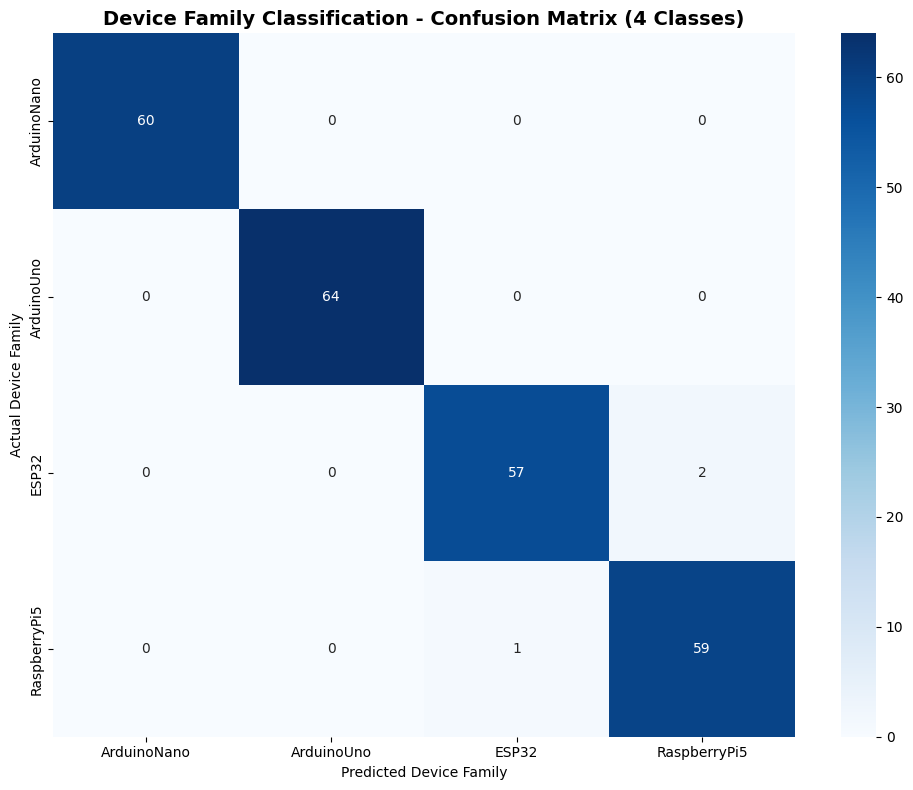


CONFUSION MATRIX 2: ALL DETAILED LABELS


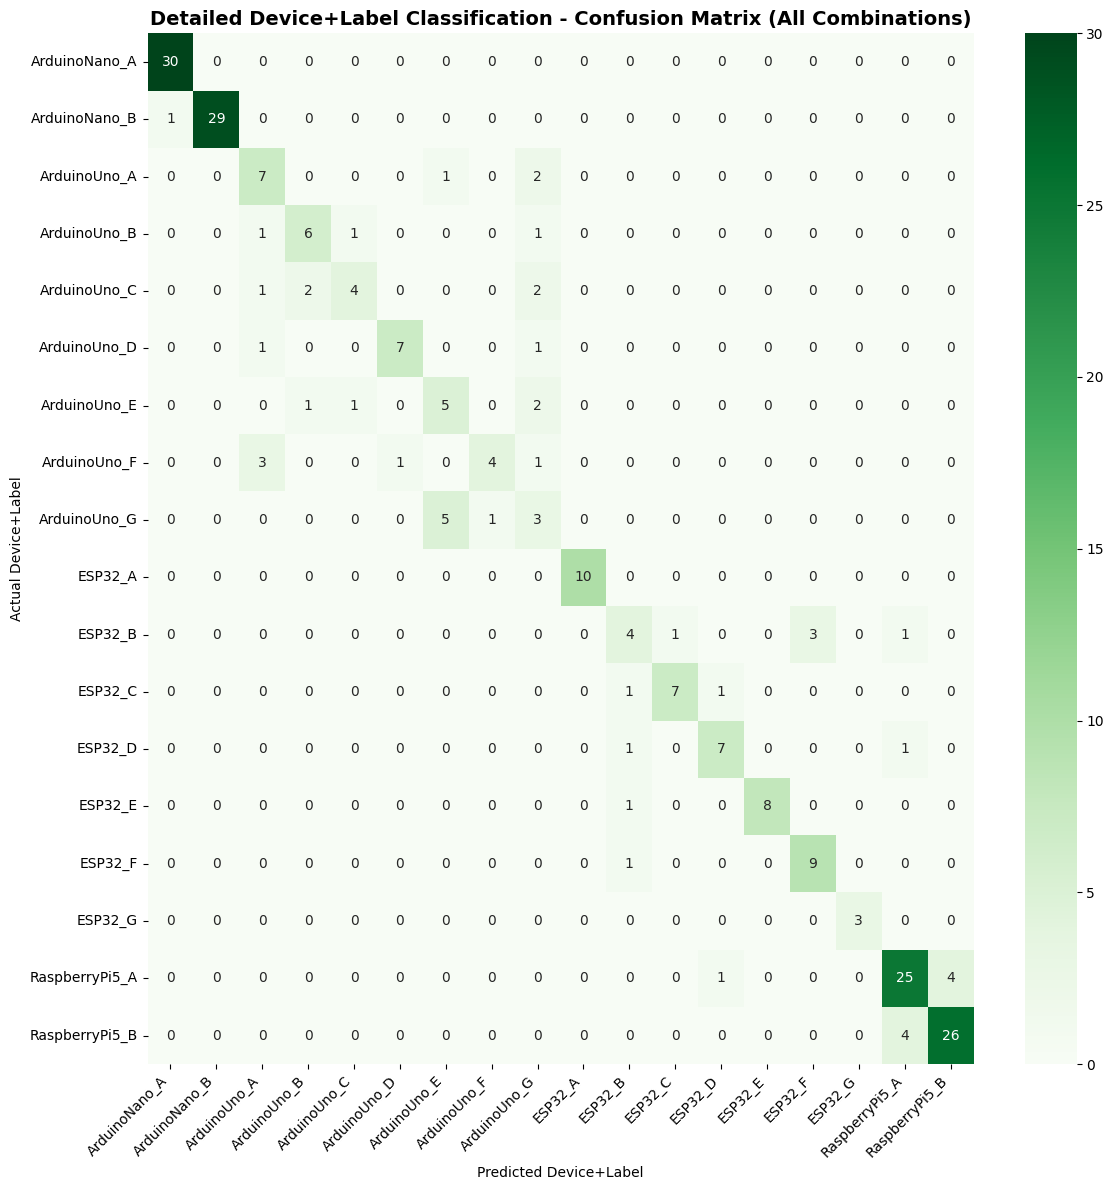


Detailed matrix shows 18 unique device+label combinations


In [78]:
# ==============================
# STEP 6: DUAL CONFUSION MATRICES
# ==============================
def get_device_family(full_label):
    """Extract device family from full label"""
    for family in ['ArduinoUno', 'ArduinoNano', 'ESP32', 'RaspberryPi5']:
        if family in full_label:
            return family
    return full_label

# CONFUSION MATRIX 1: Device Families (4x4)
print("\n" + "="*50)
print("CONFUSION MATRIX 1: DEVICE FAMILIES")
print("="*50)

y_pred_family = [get_device_family(label) for label in y_pred_full_decoded]
y_val_family_decoded = [get_device_family(label) for label in y_val_full_decoded]

family_labels = ['ArduinoNano', 'ArduinoUno', 'ESP32', 'RaspberryPi5']
cm_family = confusion_matrix(y_val_family_decoded, y_pred_family, labels=family_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_family, annot=True, fmt='d', cmap='Blues',
            xticklabels=family_labels, yticklabels=family_labels)
plt.title('Device Family Classification - Confusion Matrix (4 Classes)',
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Device Family')
plt.ylabel('Actual Device Family')
plt.tight_layout()
plt.show()

# CONFUSION MATRIX 2: All Detailed Labels
print("\n" + "="*50)
print("CONFUSION MATRIX 2: ALL DETAILED LABELS")
print("="*50)

# Get all unique labels in the validation set
all_labels = sorted(set(y_val_full_decoded) | set(y_pred_full_decoded))
cm_detailed = confusion_matrix(y_val_full_decoded, y_pred_full_decoded, labels=all_labels)

# Create a larger figure for detailed matrix
fig_size = max(12, len(all_labels) * 0.6)
plt.figure(figsize=(fig_size, fig_size))
sns.heatmap(cm_detailed, annot=True, fmt='d', cmap='Greens',
            xticklabels=all_labels, yticklabels=all_labels)
plt.title('Detailed Device+Label Classification - Confusion Matrix (All Combinations)',
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Device+Label')
plt.ylabel('Actual Device+Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"\nDetailed matrix shows {len(all_labels)} unique device+label combinations")

In [79]:
# ==============================
# STEP 7: UNIVERSAL PREDICTION CLASSIFIER
# ==============================
class SignalClassifier:
    def __init__(self, models, label_encoder_full, label_encoder_family, scaler, feature_cols):
        self.models = models
        self.label_encoder_full = label_encoder_full
        self.label_encoder_family = label_encoder_family
        self.scaler = scaler
        self.feature_cols = feature_cols

    def predict_from_csv(self, csv_path):
        """
        Predict device and label from ANY CSV file containing signal features.
        Works with any CSV that has the required feature columns.
        """
        try:
            # Load the CSV
            df = pd.read_csv(csv_path)
            print(f"Loaded CSV with shape: {df.shape}")

            # Extract features
            feature_data = df.copy()

            # Handle missing columns (fill with 0 if not present)
            for col in self.feature_cols:
                if col not in feature_data.columns:
                    feature_data[col] = 0

            X_input = feature_data[self.feature_cols]
            X_input = X_input.fillna(0)

            # Store the number of samples
            num_samples = len(X_input)

            # Scale features
            X_scaled = self.scaler.transform(X_input)

            # Get predictions from all models for all rows
            individual_predictions = {}
            row_predictions = []

            for name, model in self.models.items():
                # Predict for all rows
                preds_encoded = model.predict(X_scaled)
                # Majority vote for this model
                majority_vote = np.bincount(preds_encoded).argmax()
                pred_label = self.label_encoder_full.inverse_transform([majority_vote])[0]
                individual_predictions[name] = pred_label
                row_predictions.append(preds_encoded)

            # Ensemble prediction: majority vote across models
            all_model_preds = list(individual_predictions.values())
            ensemble_pred_full = max(set(all_model_preds), key=all_model_preds.count)
            confidence = (all_model_preds.count(ensemble_pred_full) / len(all_model_preds)) * 100

            # Extract device family
            ensemble_pred_family = get_device_family(ensemble_pred_full)

            return {
                'ensemble_prediction_full': ensemble_pred_full,
                'ensemble_prediction_family': ensemble_pred_family,
                'confidence': confidence,
                'individual_predictions': individual_predictions,
                'num_samples': num_samples # Add num_samples here
            }

        except Exception as e:
            return {'error': str(e)}

# Create classifier
signal_classifier = SignalClassifier(
    models=trained_models,
    label_encoder_full=le_full,
    label_encoder_family=le_family,
    scaler=scaler,
    feature_cols=feature_cols
)

print("\n" + "="*60)
print("UNIVERSAL SIGNAL CLASSIFIER READY!")
print("="*60)
print(f"Trained on {len(le_full.classes_)} detailed labels")
print(f"Device families: {', '.join(family_labels)}")
print(f"Using {len(feature_cols)} features")
print("\nYou can now predict from ANY CSV file with these features!")
print("="*60)


UNIVERSAL SIGNAL CLASSIFIER READY!
Trained on 18 detailed labels
Device families: ArduinoNano, ArduinoUno, ESP32, RaspberryPi5
Using 21 features

You can now predict from ANY CSV file with these features!


In [80]:
# ==============================
# STEP 8: TEST ON VALIDATION FILES
# ==============================
print("\n" + "="*70)
print("TESTING CLASSIFIER ON KNOWN DEVICE FILES (FOR VALIDATION)")
print("="*70)

test_results = []

for device_name, protocols in file_map.items():
    for protocol, file_list in protocols.items():
        for test_file in file_list:
            print(f"\n{'='*70}")
            print(f"Testing: {device_name} ({protocol})")
            print(f"File: {test_file}")
            print('='*70)

            result = signal_classifier.predict_from_csv(test_file)

            if 'error' in result:
                print(f"ERROR: {result['error']}")
                test_results.append({
                    'actual': device_name,
                    'predicted': 'ERROR',
                    'correct': False,
                    'file': test_file.split('/')[-1]
                })
            else:
                actual_device = device_name
                predicted_family = result['ensemble_prediction_family']
                predicted_full = result['ensemble_prediction_full']
                is_correct = (actual_device == predicted_family)

                print(f"\n{'✓' if is_correct else '✗'} ACTUAL DEVICE: {actual_device}")
                print(f"{'✓' if is_correct else '✗'} PREDICTED DEVICE: {predicted_family}")
                print(f"  Full Prediction: {predicted_full}")
                print(f"  Confidence: {result['confidence']:.1f}%")

                print(f"\n  Individual Model Predictions:")
                for model, pred in result['individual_predictions'].items():
                    status = "✓" if get_device_family(pred) == actual_device else "✗"
                    print(f"    {model:20s}: {pred} {status}")

                test_results.append({
                    'actual': actual_device,
                    'predicted_family': predicted_family,
                    'predicted_full': predicted_full,
                    'correct': is_correct,
                    'confidence': result['confidence'],
                    'file': test_file.split('/')[-1]
                })


TESTING CLASSIFIER ON KNOWN DEVICE FILES (FOR VALIDATION)

Testing: ArduinoNano (UART)
File: /content/UTRGV-Capstone-2025/Data/Processed/Arduino_Nano_9600_dataset.csv
Loaded CSV with shape: (300, 23)

✓ ACTUAL DEVICE: ArduinoNano
✓ PREDICTED DEVICE: ArduinoNano
  Full Prediction: ArduinoNano_A
  Confidence: 60.0%

  Individual Model Predictions:
    RandomForest        : ArduinoNano_A ✓
    SVM                 : ArduinoNano_A ✓
    KNN                 : ArduinoNano_B ✓
    LogisticRegression  : ArduinoNano_A ✓
    XGBoost             : ArduinoNano_B ✓

Testing: ArduinoUno (UART)
File: /content/UTRGV-Capstone-2025/Data/Processed/Arduino_UNO_9600_dataset.csv
Loaded CSV with shape: (320, 23)

✓ ACTUAL DEVICE: ArduinoUno
✓ PREDICTED DEVICE: ArduinoUno
  Full Prediction: ArduinoUno_A
  Confidence: 80.0%

  Individual Model Predictions:
    RandomForest        : ArduinoUno_A ✓
    SVM                 : ArduinoUno_A ✓
    KNN                 : ArduinoUno_A ✓
    LogisticRegression  : Arduino

In [81]:
# ==============================
# STEP 9: TESTING SUMMARY
# ==============================
print("\n" + "="*70)
print("TESTING SUMMARY")
print("="*70)

correct_predictions = sum(1 for r in test_results if r['correct'])
total_tests = len(test_results)
accuracy = (correct_predictions / total_tests) * 100 if total_tests > 0 else 0

print(f"\nOverall Device Family Accuracy: {accuracy:.1f}% ({correct_predictions}/{total_tests})")
print("\nDetailed Results:")
print(f"{'File':<40} {'Actual':<15} {'Predicted':<15} {'Full Label':<20} {'Confidence':<12} {'Result'}")
print("-" * 110)

for result in test_results:
    status = "✓ CORRECT" if result['correct'] else "✗ WRONG"
    predicted_full = result.get('predicted_full', 'ERROR')
    confidence = result.get('confidence', 0)
    print(f"{result['file']:<40} {result['actual']:<15} {result.get('predicted_family', 'ERROR'):<15} {predicted_full:<20} {confidence:>6.1f}%     {status}")

print("\n" + "="*70)



TESTING SUMMARY

Overall Device Family Accuracy: 100.0% (4/4)

Detailed Results:
File                                     Actual          Predicted       Full Label           Confidence   Result
--------------------------------------------------------------------------------------------------------------
Arduino_Nano_9600_dataset.csv            ArduinoNano     ArduinoNano     ArduinoNano_A          60.0%     ✓ CORRECT
Arduino_UNO_9600_dataset.csv             ArduinoUno      ArduinoUno      ArduinoUno_A           80.0%     ✓ CORRECT
ESP_32_9600_dataset.csv                  ESP32           ESP32           ESP32_F                60.0%     ✓ CORRECT
RPi_5B_9600_dataset.csv                  RaspberryPi5    RaspberryPi5    RaspberryPi5_A         60.0%     ✓ CORRECT



In [83]:
# Load mixed data
df = pd.read_csv("Combined_Device_Data.csv")

# Prepare features
X_input = df[feature_cols].fillna(0)
X_scaled = scaler.transform(X_input)

# Get predictions from all models
model_preds = {name: model.predict(X_scaled) for name, model in trained_models.items()}

# Majority vote per row
final_predictions = []
for i in range(len(df)):
    votes = [model_preds[name][i] for name in trained_models]
    majority_vote = np.bincount(votes).argmax()
    final_predictions.append(le_full.inverse_transform([majority_vote])[0])

# Add predictions to dataframe
df['Predicted_Full'] = final_predictions
df['Predicted_Family'] = df['Predicted_Full'].apply(get_device_family)
df['Correct'] = df['Device_Family'] == df['Predicted_Family']


# ==============================
# ==============================
print("\n" + "="*80)
print("SAMPLED RESULTS (5 ROWS PER DEVICE TYPE)")
print("="*80)

grouped_sample = df.groupby('Device_Family').apply(
    lambda x: x.sample(5, random_state=42)
).reset_index(drop=True)

view_cols = ['Device_Family', 'Predicted_Family', 'Predicted_Full', 'Correct']
print(grouped_sample[view_cols].to_string(index=False))

print("\n" + "="*80)
print("INSPECTING THE ERRORS (WHERE MODEL FAILED)")
print("="*80)

errors = df[df['Correct'] == False]

if not errors.empty:
    print(f"Found {len(errors)} mismatches out of {len(df)} rows:")
    print("-" * 80)
    print(errors[view_cols].to_string(index=False))
else:
    print("Incredible! There were 0 errors in this random sample.")
print("="*80)


SAMPLED RESULTS (5 ROWS PER DEVICE TYPE)
Device_Family Predicted_Family Predicted_Full  Correct
  ArduinoNano      ArduinoNano  ArduinoNano_A     True
  ArduinoNano      ArduinoNano  ArduinoNano_B     True
  ArduinoNano      ArduinoNano  ArduinoNano_B     True
  ArduinoNano      ArduinoNano  ArduinoNano_A     True
  ArduinoNano      ArduinoNano  ArduinoNano_A     True
   ArduinoUno       ArduinoUno   ArduinoUno_C     True
   ArduinoUno       ArduinoUno   ArduinoUno_F     True
   ArduinoUno       ArduinoUno   ArduinoUno_F     True
   ArduinoUno       ArduinoUno   ArduinoUno_G     True
   ArduinoUno       ArduinoUno   ArduinoUno_A     True
        ESP32            ESP32        ESP32_E     True
        ESP32            ESP32        ESP32_A     True
        ESP32            ESP32        ESP32_D     True
        ESP32            ESP32        ESP32_C     True
        ESP32            ESP32        ESP32_B     True
 RaspberryPi5     RaspberryPi5 RaspberryPi5_B     True
 RaspberryPi5     Raspb

/tmp/ipython-input-3858914659.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_sample = df.groupby('Device_Family').apply(
